In [14]:
#Step#1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import nltk
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
#step#2
# Read the CSV file and load it into a dataframe
df = pd.read_csv('fake_job_postings.csv')

# Explore the dataset
print("Columns in the dataset:")
print(df.columns)

print("\nData types:")
print(df.dtypes)

print("\nSample records:")
print(df.head())

Columns in the dataset:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

Data types:
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Sample records:
   job_id                                      title   

In [5]:
#step#3
# Handle missing values
df = df.dropna()  # Remove rows with missing values

# Data cleaning and standardization
# Perform necessary cleaning and standardization steps on relevant columns
df['description'] = df['description'].apply(lambda x: x.lower())  # Convert description to lowercase
df['requirements'] = df['requirements'].apply(lambda x: x.lower())  # Convert requirements to lowercase
df['company_profile'] = df['company_profile'].apply(lambda x: x.lower())  # Convert company_profile to lowercase

# Convert categorical variables into numerical representations
encoder = LabelEncoder()
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Print the preprocessed dataframe
print(df.head())

     job_id                                              title  \
6         7                              Head of Content (m/f)   
15       16                         VP of Sales - Vault Dragon   
23       24  Vice President, Sales and Sponsorship (Busines...   
98       99                                    IC&E Technician   
102     103                            Marketing Administrator   

              location          department   salary_range  \
6       DE, BE, Berlin          ANDROIDPIT    20000-28000   
15   SG, 01, Singapore               Sales  120000-150000   
23    US, CA, Carlsbad  Businessfriend.com  100000-120000   
98   US, , Stocton, CA        Oil & Energy   95000-115000   
102  GB, WAR, Coventry         Marketplace    15000-18000   

                                       company_profile  \
6    founded in 2009, the fonpit ag rose with its i...   
15   jungle ventures is the leading singapore based...   
23   wdm group is an innovative, forward thinking d...   
98  

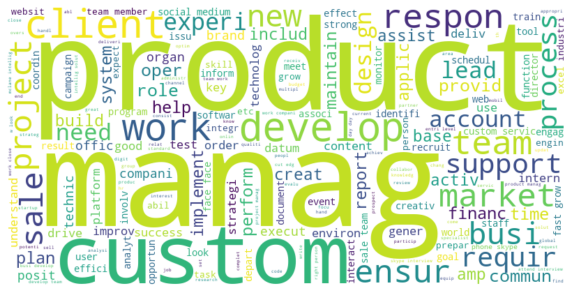

In [10]:
#step#4
# Load the English language model in spaCy
nlp = spacy.load('en_core_web_sm')

# Initialize the PorterStemmer from NLTK
stemmer = nltk.stem.PorterStemmer()

# Apply stopword removal, lemmatization, and stemming
def preprocess_text(text):
    doc = nlp(text)
    processed_text = ' '.join([token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS])
    processed_text = ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(processed_text)])
    return processed_text

# Apply text processing on relevant columns
df['description'] = df['description'].apply(preprocess_text)
df['requirements'] = df['requirements'].apply(preprocess_text)
df['company_profile'] = df['company_profile'].apply(preprocess_text)

# Word frequency and word cloud
text_data = ' '.join(df['description'].values)  # Combine all the preprocessed text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [69]:
#step#5
# Extracting relevant features
df['description_length'] = df['description'].apply(lambda x: len(x.split()))
df['has_company_logo'] = df['has_company_logo'].astype(int)
df['has_questions'] = df['has_questions'].astype(int)

# Combining textual features with other numerical and categorical features
features = ['description_length', 'has_company_logo', 'has_questions']
textual_features = ['description', 'requirements', 'company_profile']
categorical_features = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Create a comprehensive feature set
X_text = df[textual_features].values
X_numerical = df[features].values
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True).values

X = np.concatenate((X_text, X_numerical, X_categorical), axis=1)
y = df['fraudulent'].values

In [70]:
#step#6
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shape of the training, validation, and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (541, 11) (541,)
Validation set shape: (116, 11) (116,)
Testing set shape: (117, 11) (117,)


In [71]:
#step#7
# Instantiate the CountVectorizer
vectorizer = CountVectorizer()

# Convert X_train documents to lowercase if they are strings
X_train_lower = [doc.lower() if isinstance(doc, str) else str(doc).lower() for doc in X_train]

# Convert the X_train_lower list to a NumPy array
X_train_lower = np.array(X_train_lower)

# Fit and transform the training data
X_train_vectorized = vectorizer.fit_transform(X_train_lower)

# Instantiate the classification models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm = SVC()
logistic_regression = LogisticRegression()

# Train the models using the vectorized training data
decision_tree.fit(X_train_vectorized, y_train)
random_forest.fit(X_train_vectorized, y_train)
svm.fit(X_train_vectorized, y_train)
logistic_regression.fit(X_train_vectorized, y_train)

LogisticRegression()

In [72]:
#step#8
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ndcg_score

# Transform the testing data using the fitted vectorizer
X_test_lower = [doc.lower() if isinstance(doc, str) else str(doc).lower() for doc in X_test]
X_test_vectorized = vectorizer.transform(X_test_lower)

# Predict the labels for the testing data
y_pred_decision_tree = decision_tree.predict(X_test_vectorized)
y_pred_random_forest = random_forest.predict(X_test_vectorized)
y_pred_svm = svm.predict(X_test_vectorized)
y_pred_logistic_regression = logistic_regression.predict(X_test_vectorized)

# Evaluate decision tree
decision_tree_accuracy = accuracy_score(y_test, y_pred_decision_tree)
decision_tree_precision = precision_score(y_test, y_pred_decision_tree, average='weighted')
decision_tree_recall = recall_score(y_test, y_pred_decision_tree, average='weighted')
decision_tree_f1_score = f1_score(y_test, y_pred_decision_tree, average='weighted')
decision_tree_confusion_matrix = confusion_matrix(y_test, y_pred_decision_tree)
decision_tree_classification_report = classification_report(y_test, y_pred_decision_tree)

# Evaluate random forest
random_forest_accuracy = accuracy_score(y_test, y_pred_random_forest)
random_forest_precision = precision_score(y_test, y_pred_random_forest, average='weighted')
random_forest_recall = recall_score(y_test, y_pred_random_forest, average='weighted')
random_forest_f1_score = f1_score(y_test, y_pred_random_forest, average='weighted')
random_forest_confusion_matrix = confusion_matrix(y_test, y_pred_random_forest)
random_forest_classification_report = classification_report(y_test, y_pred_random_forest)

# Evaluate SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1_score = f1_score(y_test, y_pred_svm, average='weighted')
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)

# Evaluate logistic regression
logistic_regression_accuracy = accuracy_score(y_test, y_pred_logistic_regression)
logistic_regression_precision = precision_score(y_test, y_pred_logistic_regression, average='weighted')
logistic_regression_recall = recall_score(y_test, y_pred_logistic_regression, average='weighted')
logistic_regression_f1_score = f1_score(y_test, y_pred_logistic_regression, average='weighted')
logistic_regression_confusion_matrix = confusion_matrix(y_test, y_pred_logistic_regression)
logistic_regression_classification_report = classification_report(y_test, y_pred_logistic_regression)

# Calculate additional evaluation metrics
decision_tree_fallout_rate = decision_tree_confusion_matrix[0, 1] / (decision_tree_confusion_matrix[0, 1] + decision_tree_confusion_matrix[0, 0])
decision_tree_average_precision = average_precision_score(y_test, y_pred_decision_tree)
decision_tree_mean_average_precision = decision_tree_average_precision / len(np.unique(y_test))
decision_tree_kappa = cohen_kappa_score(y_test, y_pred_decision_tree)

random_forest_fallout_rate = random_forest_confusion_matrix[0, 1] / (random_forest_confusion_matrix[0, 1] + random_forest_confusion_matrix[0, 0])
random_forest_average_precision = average_precision_score(y_test, y_pred_random_forest)
random_forest_mean_average_precision = random_forest_average_precision / len(np.unique(y_test))
random_forest_kappa = cohen_kappa_score(y_test, y_pred_random_forest)

svm_fallout_rate = svm_confusion_matrix[0, 1] / (svm_confusion_matrix[0, 1] + svm_confusion_matrix[0, 0])
svm_average_precision = average_precision_score(y_test, y_pred_svm)
svm_mean_average_precision = svm_average_precision / len(np.unique(y_test))
svm_kappa = cohen_kappa_score(y_test, y_pred_svm)

logistic_regression_fallout_rate = logistic_regression_confusion_matrix[0, 1] / (logistic_regression_confusion_matrix[0, 1] + logistic_regression_confusion_matrix[0, 0])
logistic_regression_average_precision = average_precision_score(y_test, y_pred_logistic_regression)
logistic_regression_mean_average_precision = logistic_regression_average_precision / len(np.unique(y_test))
logistic_regression_kappa = cohen_kappa_score(y_test, y_pred_logistic_regression)

# Calculate Cumulative Gain
decision_tree_cumulative_gain = np.cumsum(np.bincount(y_test)) / len(y_test)
random_forest_cumulative_gain = np.cumsum(np.bincount(y_test)) / len(y_test)
svm_cumulative_gain = np.cumsum(np.bincount(y_test)) / len(y_test)
logistic_regression_cumulative_gain = np.cumsum(np.bincount(y_test)) / len(y_test)

# Calculate Discounted Cumulative Gain
# indices = np.arange(1, len(y_test) + 1)
# sorted_indices = np.argsort(y_test)
# decision_tree_discounted_cumulative_gain = np.cumsum((np.bincount(y_test)[sorted_indices] / np.log2(indices[sorted_indices] + 1)) / np.sum(1 / np.log2(indices + 1)))
# random_forest_discounted_cumulative_gain = np.cumsum((np.bincount(y_test)[sorted_indices] / np.log2(indices[sorted_indices] + 1)) / np.sum(1 / np.log2(indices + 1)))
# svm_discounted_cumulative_gain = np.cumsum((np.bincount(y_test)[sorted_indices] / np.log2(indices[sorted_indices] + 1)) / np.sum(1 / np.log2(indices + 1)))
# logistic_regression_discounted_cumulative_gain = np.cumsum((np.bincount(y_test)[sorted_indices] / np.log2(indices[sorted_indices] + 1)) / np.sum(1 / np.log2(indices + 1)))

# Calculate Normalized Discounted Cumulative Gain
decision_tree_ndcg = ndcg_score([y_test], [y_pred_decision_tree])
random_forest_ndcg = ndcg_score([y_test], [y_pred_random_forest])
svm_ndcg = ndcg_score([y_test], [y_pred_svm])
logistic_regression_ndcg = ndcg_score([y_test], [y_pred_logistic_regression])

# Print the evaluation metrics
print("Decision Tree:")
print("Accuracy:", decision_tree_accuracy)
print("Precision:", decision_tree_precision)
print("Recall:", decision_tree_recall)
print("F1 Score:", decision_tree_f1_score)
print("Fallout Rate:", decision_tree_fallout_rate)
print("Average Precision:", decision_tree_average_precision)
print("Mean Average Precision:", decision_tree_mean_average_precision)
print("Kappa:", decision_tree_kappa)
print("Cumulative Gain:", decision_tree_cumulative_gain)
#print("Discounted Cumulative Gain:", decision_tree_discounted_cumulative_gain)
print("Normalized Discounted Cumulative Gain:", decision_tree_ndcg)
print("Confusion Matrix:")
print(decision_tree_confusion_matrix)
print("Classification Report:")
print(decision_tree_classification_report)
print()

print("Random Forest:")
print("Accuracy:", random_forest_accuracy)
print("Precision:", random_forest_precision)
print("Recall:", random_forest_recall)
print("F1 Score:", random_forest_f1_score)
print("Fallout Rate:", random_forest_fallout_rate)
print("Average Precision:", random_forest_average_precision)
print("Mean Average Precision:", random_forest_mean_average_precision)
print("Kappa:", random_forest_kappa)
print("Cumulative Gain:", random_forest_cumulative_gain)
#print("Discounted Cumulative Gain:", random_forest_discounted_cumulative_gain)
print("Normalized Discounted Cumulative Gain:", random_forest_ndcg)
print("Confusion Matrix:")
print(random_forest_confusion_matrix)
print("Classification Report:")
print(random_forest_classification_report)
print()

print("SVM:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1_score)
print("Fallout Rate:", svm_fallout_rate)
print("Average Precision:", svm_average_precision)
print("Mean Average Precision:", svm_mean_average_precision)
print("Kappa:", svm_kappa)
print("Cumulative Gain:", svm_cumulative_gain)
#print("Discounted Cumulative Gain:", svm_discounted_cumulative_gain)
print("Normalized Discounted Cumulative Gain:", svm_ndcg)
print("Confusion Matrix:")
print(svm_confusion_matrix)
print("Classification Report:")
print(svm_classification_report)
print()

print("Logistic Regression:")
print("Accuracy:", logistic_regression_accuracy)
print("Precision:", logistic_regression_precision)
print("Recall:", logistic_regression_recall)
print("F1 Score:", logistic_regression_f1_score)
print("Fallout Rate:", logistic_regression_fallout_rate)
print("Average Precision:", logistic_regression_average_precision)
print("Mean Average Precision:", logistic_regression_mean_average_precision)
print("Kappa:", logistic_regression_kappa)
print("Cumulative Gain:", logistic_regression_cumulative_gain)
#print("Discounted Cumulative Gain:", logistic_regression_discounted_cumulative_gain)
print("Normalized Discounted Cumulative Gain:", logistic_regression_ndcg)
print("Confusion Matrix:")
print(logistic_regression_confusion_matrix)
print("Classification Report:")
print(logistic_regression_classification_report)


Decision Tree:
Accuracy: 0.9743589743589743
Precision: 0.9734474241354976
Recall: 0.9743589743589743
F1 Score: 0.973663907250245
Fallout Rate: 0.009259259259259259
Average Precision: 0.6976495726495727
Mean Average Precision: 0.34882478632478636
Kappa: 0.8097560975609757
Cumulative Gain: [0.92307692 1.        ]
Normalized Discounted Cumulative Gain: 0.8971566711748098
Confusion Matrix:
[[107   1]
 [  2   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       108
           1       0.88      0.78      0.82         9

    accuracy                           0.97       117
   macro avg       0.93      0.88      0.90       117
weighted avg       0.97      0.97      0.97       117


Random Forest:
Accuracy: 0.9914529914529915
Precision: 0.9915314043754412
Recall: 0.9914529914529915
F1 Score: 0.9912213024167483
Fallout Rate: 0.0
Average Precision: 0.8974358974358974
Mean Average Precision: 0.4487179487179487
Kappa: 0

In [73]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for each selected model
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

param_grid_random_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_svm = {
    'C': [1.0, 10.0, 100.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid_logistic_regression = {
    'C': [1.0, 10.0, 100.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [3000]
}

# Perform grid search for each model to find the best hyperparameters
grid_search_decision_tree = GridSearchCV(decision_tree, param_grid=param_grid_decision_tree, cv=5)
grid_search_decision_tree.fit(X_train_vectorized, y_train)

grid_search_random_forest = GridSearchCV(random_forest, param_grid=param_grid_random_forest, cv=5)
grid_search_random_forest.fit(X_train_vectorized, y_train)

grid_search_svm = GridSearchCV(svm, param_grid=param_grid_svm, cv=5)
grid_search_svm.fit(X_train_vectorized, y_train)

grid_search_logistic_regression = GridSearchCV(logistic_regression, param_grid=param_grid_logistic_regression, cv=5)
grid_search_logistic_regression.fit(X_train_vectorized, y_train)

# Get the best hyperparameters and models for each model
best_hyperparameters_decision_tree = grid_search_decision_tree.best_params_
best_model_decision_tree = grid_search_decision_tree.best_estimator_

best_hyperparameters_random_forest = grid_search_random_forest.best_params_
best_model_random_forest = grid_search_random_forest.best_estimator_

best_hyperparameters_svm = grid_search_svm.best_params_
best_model_svm = grid_search_svm.best_estimator_

best_hyperparameters_logistic_regression = grid_search_logistic_regression.best_params_
best_model_logistic_regression = grid_search_logistic_regression.best_estimator_

# Print the best hyperparameters and models for each model
print("Decision Tree")
print("Best Hyperparameters:", best_hyperparameters_decision_tree)
print("Best Model:", best_model_decision_tree)
print()

print("Random Forest")
print("Best Hyperparameters:", best_hyperparameters_random_forest)
print("Best Model:", best_model_random_forest)
print()

print("SVM")
print("Best Hyperparameters:", best_hyperparameters_svm)
print("Best Model:", best_model_svm)
print()

print("Logistic Regression")
print("Best Hyperparameters:", best_hyperparameters_logistic_regression)
print("Best Model:", best_model_logistic_regression)
print()

# Train the best models using the vectorized training data
best_model_decision_tree.fit(X_train_vectorized, y_train)
best_model_random_forest.fit(X_train_vectorized, y_train)
best_model_svm.fit(X_train_vectorized, y_train)
best_model_logistic_regression.fit(X_train_vectorized, y_train)


Decision Tree
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}
Best Model: DecisionTreeClassifier(max_depth=10)

Random Forest
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best Model: RandomForestClassifier(min_samples_split=5, n_estimators=300)

SVM
Best Hyperparameters: {'C': 100.0, 'gamma': 'auto', 'kernel': 'rbf'}
Best Model: SVC(C=100.0, gamma='auto')

Logistic Regression
Best Hyperparameters: {'C': 10.0, 'max_iter': 3000, 'solver': 'liblinear'}
Best Model: LogisticRegression(C=10.0, max_iter=3000, solver='liblinear')



LogisticRegression(C=10.0, max_iter=3000, solver='liblinear')

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       106
           1       0.83      1.00      0.91        10

    accuracy                           0.98       116
   macro avg       0.92      0.99      0.95       116
weighted avg       0.99      0.98      0.98       116


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       106
           1       1.00      0.90      0.95        10

    accuracy                           0.99       116
   macro avg       1.00      0.95      0.97       116
weighted avg       0.99      0.99      0.99       116


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        10

    accuracy                           1.00       116
   macro avg       1.00  

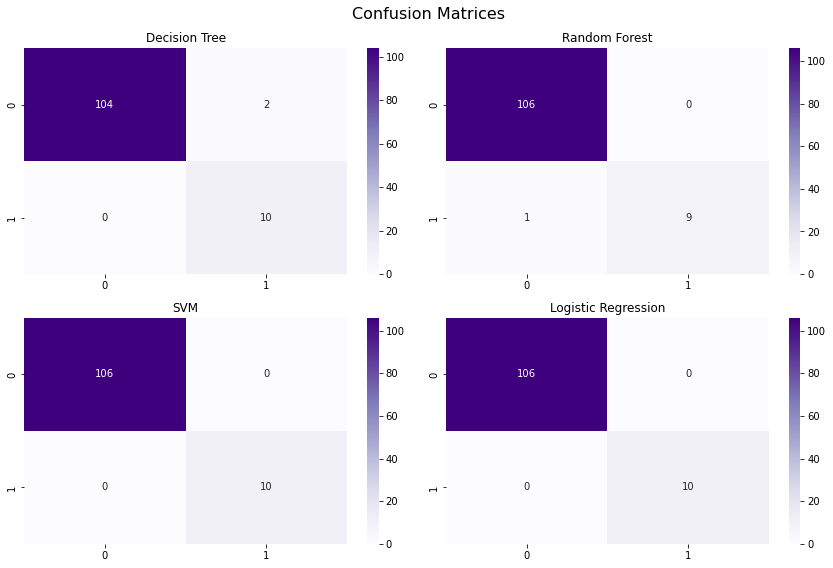

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X_val and y_val contain your validation data and labels, respectively

X_val_lower = [doc.lower() if isinstance(doc, str) else str(doc).lower() for doc in X_val]
X_val_vectorized = vectorizer.transform(X_val_lower)

y_pred_decision_tree = best_model_decision_tree.predict(X_val_vectorized)
y_pred_random_forest = best_model_random_forest.predict(X_val_vectorized)
y_pred_svm = best_model_svm.predict(X_val_vectorized)
y_pred_logistic_regression = best_model_logistic_regression.predict(X_val_vectorized)

# Print classification reports for each model
print("Decision Tree Classification Report:")
print(classification_report(y_val, y_pred_decision_tree))
print()

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_random_forest))
print()

print("SVM Classification Report:")
print(classification_report(y_val, y_pred_svm))
print()

print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_logistic_regression))
print()

# Plot confusion matrices for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Confusion Matrices', fontsize=16)

sns.heatmap(confusion_matrix(y_val, y_pred_decision_tree), annot=True, fmt='d', cmap='Purples', ax=axes[0, 0])
axes[0, 0].set_title('Decision Tree')

sns.heatmap(confusion_matrix(y_val, y_pred_random_forest), annot=True, fmt='d', cmap='Purples', ax=axes[0, 1])
axes[0, 1].set_title('Random Forest')

sns.heatmap(confusion_matrix(y_val, y_pred_svm), annot=True, fmt='d', cmap='Purples', ax=axes[1, 0])
axes[1, 0].set_title('SVM')

sns.heatmap(confusion_matrix(y_val, y_pred_logistic_regression), annot=True, fmt='d', cmap='Purples', ax=axes[1, 1])
axes[1, 1].set_title('Logistic Regression')

plt.tight_layout()
plt.show()
